In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [242]:
customer_data = pd.read_csv('C:/Users/HP/Downloads/cleaned_customer_data.csv')

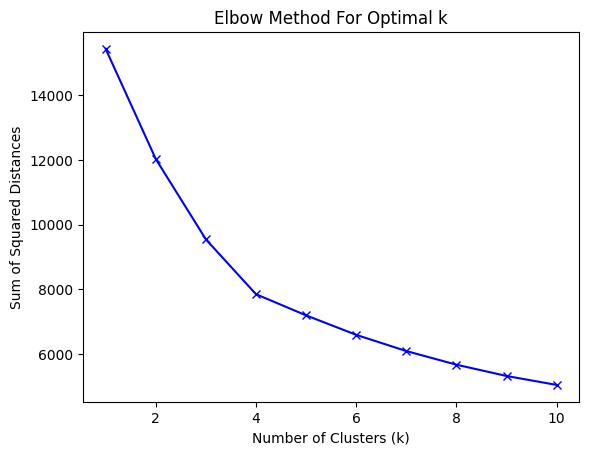

In [243]:
X = customer_data.drop('CustomerID', axis=1)
ssd = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')

plt.show()

In [244]:
#the curve starts to flatten from k = 4

In [245]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data.drop('CustomerID', axis=1))

In [246]:
customer_data['Cluster'] = customer_data['Cluster'].astype('object')
customer_data['Cluster'].describe()

count     4285
unique       4
top          0
freq      1371
Name: Cluster, dtype: int64

In [247]:
cluster_counts = customer_data['Cluster'].value_counts()
print(cluster_counts)

Cluster
0    1371
3    1240
2     842
1     832
Name: count, dtype: int64


In [248]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, customer_data['Cluster'])
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.2361337326910901


In [249]:
from sklearn.metrics import davies_bouldin_score
features = ['Days_Since_Last_Purchase', 'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased', 'Average_Days_Between_Purchases', 'Preferred_Day', 'Preferred_Hour', 'Cancellation_Rate']
db_index = davies_bouldin_score(customer_data[features], customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.2924683404613273


In [250]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(customer_data[features], customer_data['Cluster'])
print(f'Calinski-Harabasz Index: {ch_index}')

Calinski-Harabasz Index: 1378.02878299043


In [251]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Preferred_Day,Preferred_Hour,Cancellation_Rate,Cluster
0,12346.0,2.287486,-0.230905,-0.832817,-0.714604,-0.299819,-0.834842,-1.075973,0.141005,2
1,12347.0,-0.882385,0.199861,0.757769,0.475123,-0.123620,-0.834842,0.656500,-0.351825,3
2,12348.0,-0.145441,-0.058484,0.095395,-0.481324,0.381858,0.247711,2.605533,-0.351825,3
3,12349.0,-0.720863,-0.056048,0.957947,0.113540,-0.299819,-1.376118,-1.509091,-0.351825,0
4,12350.0,2.226915,-0.195587,-0.072288,-0.539644,-0.299819,-0.293565,1.522737,-0.351825,2


In [252]:
#Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df.merge(customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

#Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['Cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['Cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('Cluster').head(10)

#Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'Cluster', 'StockCode'])['Quantity'].sum().reset_index()

#Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['Cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['Cluster'] == cluster]
    customers_in_cluster = customer_data[customer_data['Cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['Cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

#Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'Cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])


In [253]:
recommendations_df.head()

,CustomerID,Cluster,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
0,12349.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES
1,12356.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,22616,PACK OF 12 LONDON TISSUES
2,12358.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES
3,12359.0,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES,23084,RABBIT NIGHT LIGHT
4,12370.0,0,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES


In [254]:
recommendations_df.shape

(4285, 8)